# Dataset 1 - Adult Data Set

## Data loading and processing

Load the dataset form 'adult.data'. Convert categorical features into numbers and convert missing values into -1.

In [20]:
import numpy as np

#feature names and categorical features
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
category_features = np.array([1,3,5,6,7,8,9,13])
categories = {'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
              'education': ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
              'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
              'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing','Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
              'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
              'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
              'sex': ['Female', 'Male'],
              'native-country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']}
    
#Convert categorical features into numbers and convert missing values into -1.
def find_category(string, index):
    l = categories[features[index]]
    if string in l:
        return l.index(string)
    return -1

converters = {}
for i in category_features:
    def lambda_generator(i):
       return lambda s: find_category(s.strip(), i)
    converters[i] = lambda_generator(i)
converters[len(features)] = lambda s: 1 if '>50K' in s else 0

data = np.loadtxt('./adult.data', dtype=int, encoding='utf-8-sig', delimiter=', ', converters=converters)
print('The shape of the dataset is', data.shape)

The shape of the dataset is (32561, 15)


Clean the Data.

Remove instances that have 3 or more missing data entries.

Impute missing values with most frequent value of each column.

In [21]:
#clean the traing data

from sklearn.impute import SimpleImputer

#seperate X and y from data
y_train = data[:, -1]
X_train = np.delete(data, -1, axis=1)

#delete rows which contain missing data points
missing_count = np.count_nonzero(X_train == -1, axis=1)
X_train = np.delete(X_train, np.where(missing_count>2), axis=0)
y_train = np.delete(y_train, np.where(missing_count>2), axis=0)
print('The shape of the dataset after deleting is', X_train.shape)

#Impute missing values with most frequent value of each column.
imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
X_train = imp.fit_transform(X_train)

The shape of the dataset after deleting is (32534, 14)


In [22]:
#one-hot-coding
from sklearn.preprocessing import OneHotEncoder
'''
#self-implementation of one-hot-coding
def one_hot_coding(X):
    #for each category feature, do one-hot coding
    for index in category_features:
        feature_data = X[:, index]
        one_hot = np.zeros((feature_data.size, len(categories[features[index]])), dtype=int)
        rows = np.arange(feature_data.size)
        one_hot[rows, feature_data] = 1
        X = np.concatenate((X, one_hot), axis = 1)
        
    #delete original data of category features
    X = np.delete(X, category_features, axis=1)
    return X

#feture names after one-hot coding
feature_names = np.array(features, dtype=str)
for index in category_features:
    feature_names = np.concatenate((feature_names, np.array(categories[features[index]])))
feature_names = np.delete(feature_names, category_features)
'''

X_categories = X_train[:,category_features]
enc = OneHotEncoder(dtype=int)
enc.fit(X_categories)
X_categories = enc.fit_transform(X_categories).toarray()
X_train = np.delete(X_train, category_features, axis=1)
X_train = np.concatenate((X_train, X_categories), axis = 1)
print('The shape of the dataset after one-hot coding is', X_train.shape)


The shape of the dataset after one-hot coding is (32534, 105)
[[    39  77516     13   2174      0     40      0      0      0      0
       0      1      0      0      1      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      1      0      0      0      0      0      0      0
       0      0      0      0      0      1      0      0      0      0
       0      0      0      0      1      0      0      1      0      0
       0      0      0      1      1      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [    50  83311     13      0      0     13      0      1      0      0
       0      0      0      0      1      0      0      0      0      0
       0      0      0      0      0

## Visualize the distribution of data.

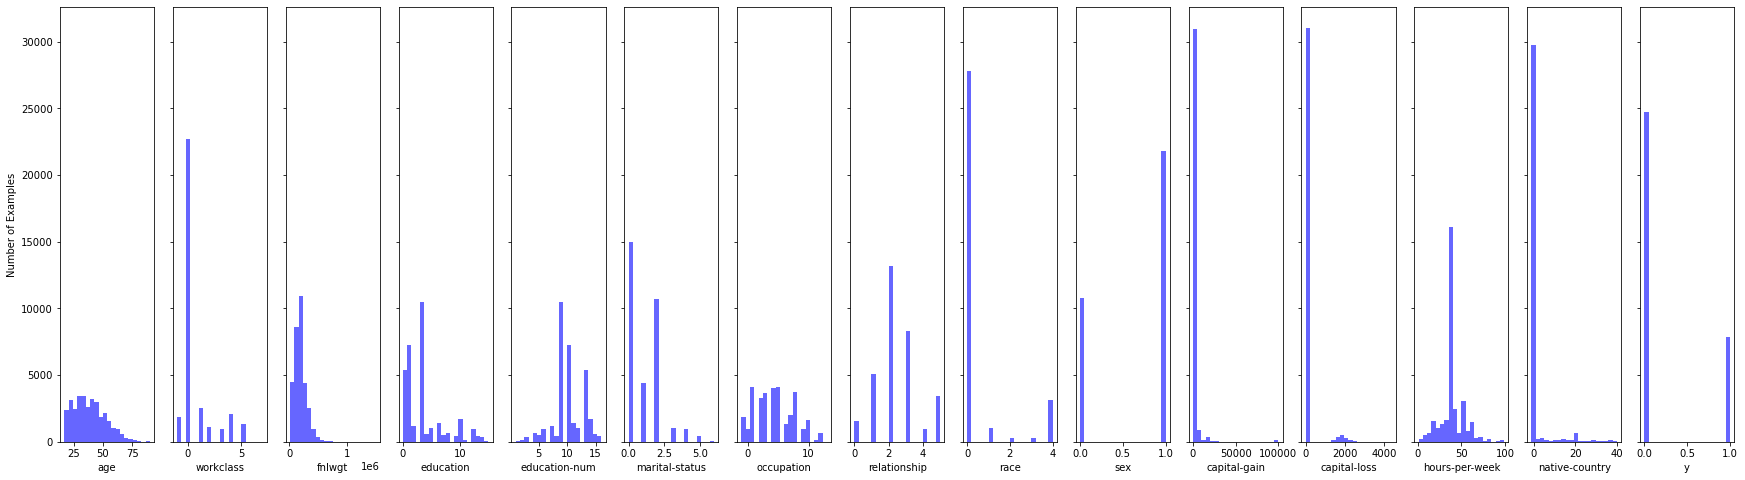

In [23]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, data.shape[1], sharey=True)
fig.set_size_inches(30, 8)
for i, ax in enumerate(axs):
    ax.hist(data[:, i], 20, facecolor='b', alpha=0.6)
    if i<len(features): ax.set_xlabel(f'{features[i]}')
    else: ax.set_xlabel(f'y')
axs[0].set_ylabel('Number of Examples')
plt.show()


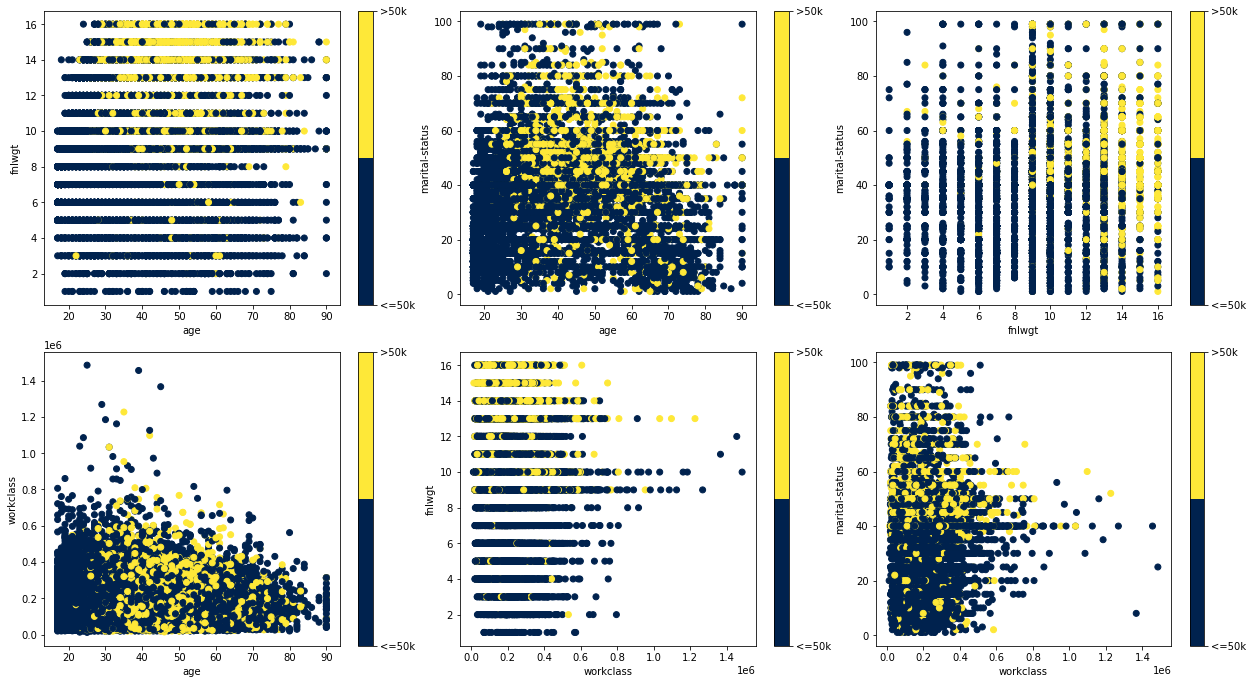

In [24]:
plt.figure(figsize=(18, 10))
for pairidx, pair in enumerate([[0,2], [0,5], [2,5], [0,1], [1,2], [1,5]]):
    plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    x1_index, x2_index = pair[0], pair[1]
    formatter = plt.FuncFormatter(lambda i, *args: '>50k' if i==1 else '<=50k')
    plt.scatter(X_train[:,x1_index], X_train[:,x2_index], c=y_train, cmap=plt.cm.get_cmap('cividis',2))
    plt.colorbar(ticks=[0,1], format=formatter)
    plt.xlabel(feature_names[x1_index])
    plt.ylabel(feature_names[x2_index])

## KNN

### Use 5-fold cross-validation to pick the best K value of KNN model

In [122]:
#CV implementation
def cross_validation(model, X, y, k_fold = 5):
    """
    method: cross_validation
    params: Model(object used to fit data) model
      numpy array (array-like) Data X
      numpy array (array-like) Labels y
      int k_fold (default value set to 5)
    return: A tuple containing the Model(Final Model with best accuracy) final_model and float best_accuracy - average validation accuracy
    """
    best_accuracy = 0
    start = math.ceil((X.shape[0]/k_fold)*(k_fold-1))
    end = X.shape[0]
    model_accuracies = list()

    "Mashbayar, to delete: The original method threw some weird key error, so just using the scikit implementation of the same thing"
    # shuffle the training data
    #np.random.seed(1)
    #np.random.shuffle(X)
    #np.random.seed(1)
    #np.random.shuffle(y)
    
    X, y = shuffle(X, y)

    # k_fold
    for i in range(k_fold):

        # split into training and validation data
        validation_X = X.iloc[start: end]
        validation_y = y.iloc[start: end]

        training_X = X[~X.index.isin(validation_X.index)]
        training_y = y[~y.index.isin(validation_y.index)]
        #training_X = np.setdiff1d(X, validation_X)
        #training_y = np.setdiff1d(y, validation_y)

        # fit the model
        model.fit(training_X, training_y)

        # predict on validation data
        y_pred = model.predict(validation_X)
        acc = np.mean(y_pred == validation_y)
        model_accuracies.append(acc)

        "Mashbayar, to delete: I don't think we need to return best model since they all have the same hyperparameters. Hyperparameter optimization is done outside of this." 
        "We're mostly trying to have a better accuracy score, right?"
        # pick the model with the best accuracy
        #if acc > best_accuracy:
        #    best_accuracy = acc
        #    final_model = model

        end = start
        start = math.ceil(start - (X.shape[0]/k_fold))

    return np.mean(model_accuracies)

In [155]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

best_acc = 0
accuracy = np.zeros(50)
#enumerate the value of K
for n_neighbors in np.arange(1,50):
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    #find the best 5-fold cross validation score accuracy
    acc = cross_val_score(knn_model, X_train, y_train, cv=5).mean()
    accuracy[n_neighbors] = acc
    if acc > best_acc:
        best_K = n_neighbors
        best_acc = acc
        best_knn_model = knn_model
print(f'best cross validation accuracy : {best_acc:.3f} when K= {best_K}')

best cross validation accuracy : 0.799 when K= 31


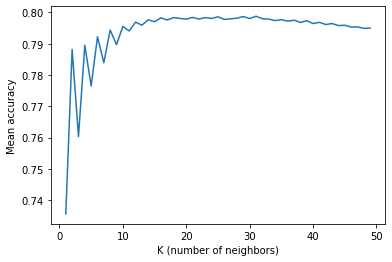

In [156]:
plt.plot(range(1,50), accuracy[1:])
plt.ylabel('Mean accuracy')
plt.xlabel('K (number of neighbors)')
plt.show()

### Prediction

In [173]:
#load test data
test = np.loadtxt('./adult.test', dtype=int, encoding='utf-8-sig', delimiter=', ', skiprows=1, converters=converters)
#seperate X and y of test data
y_test = test[:, -1]
X_test = np.delete(test, -1, axis=1)
#do one-hot-coding
X_test = one_hot_coding(X_test)
print('The shape of the testset is', test.shape)

The shape of the testset is (16281, 15)


In [177]:
#prediction
best_knn_model.fit(X_train, y_train)
y_pred = best_knn_model.predict(X_test)
acc = np.mean(y_pred == y_test)
print('The accuracy of KNN model with K=', best_K, 'is ', f'{acc:.4f}')

The accuracy of KNN model with K= 31 is  0.8027


<AxesSubplot:>

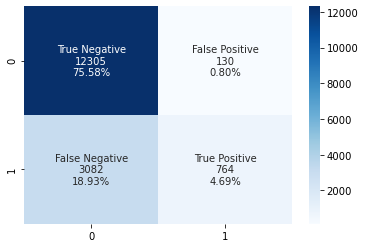

In [178]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

## Desicion Tree

### Use 5-fold cross-validation to pick the best parameters (max_depth, min_samples_leaf, min_impurity_decrease)

In [102]:
from sklearn.tree import DecisionTreeClassifier

#choices of hyperparameter 
max_depth_values = np.arange(5, 16)
min_samples_leaf_values = np.arange(10,40) * 2
min_impurity_decrease_values = np.arange(20) * 0.00002


total_models = max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size
accuracy = np.zeros(max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size).reshape(max_depth_values.size, min_samples_leaf_values.size, min_impurity_decrease_values.size)
best_acc = 0
cur_per, count = -1, 0

#try all hyperparameter combinations
for max_depth in range(max_depth_values.size):
    for min_samples_leaf in  range(min_samples_leaf_values.size):
        for min_impurity_decrease in range(min_impurity_decrease_values.size):
            clf = DecisionTreeClassifier(max_depth=max_depth_values[max_depth], min_samples_leaf=min_samples_leaf_values[min_samples_leaf], min_impurity_decrease=min_impurity_decrease_values[min_impurity_decrease])
            #find the best 5-fold cross validation score accuracy
            acc = cross_val_score(clf, X_train, y_train, cv=5).mean()
            accuracy[max_depth, min_samples_leaf, min_impurity_decrease] = acc
            if acc > best_acc:
                best_cfg = (max_depth_values[max_depth], min_samples_leaf_values[min_samples_leaf], min_impurity_decrease_values[min_impurity_decrease])
                best_acc = acc
                best_decistion_tree_model = clf

print(best_acc, best_cfg)


0.015151515151515152 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
100.0 %
0.8547182197735619 (15, 20, 0.00018)


"\nplt.plot(range(2,31), accuracy[2:])\nplt.xlim(2,30)\nplt.ylim(0.75,0.86)\nplt.ylabel('Mean accuracy')\nplt.xlabel('max_depth')\nplt.show()\n"

### Visualize the best tree

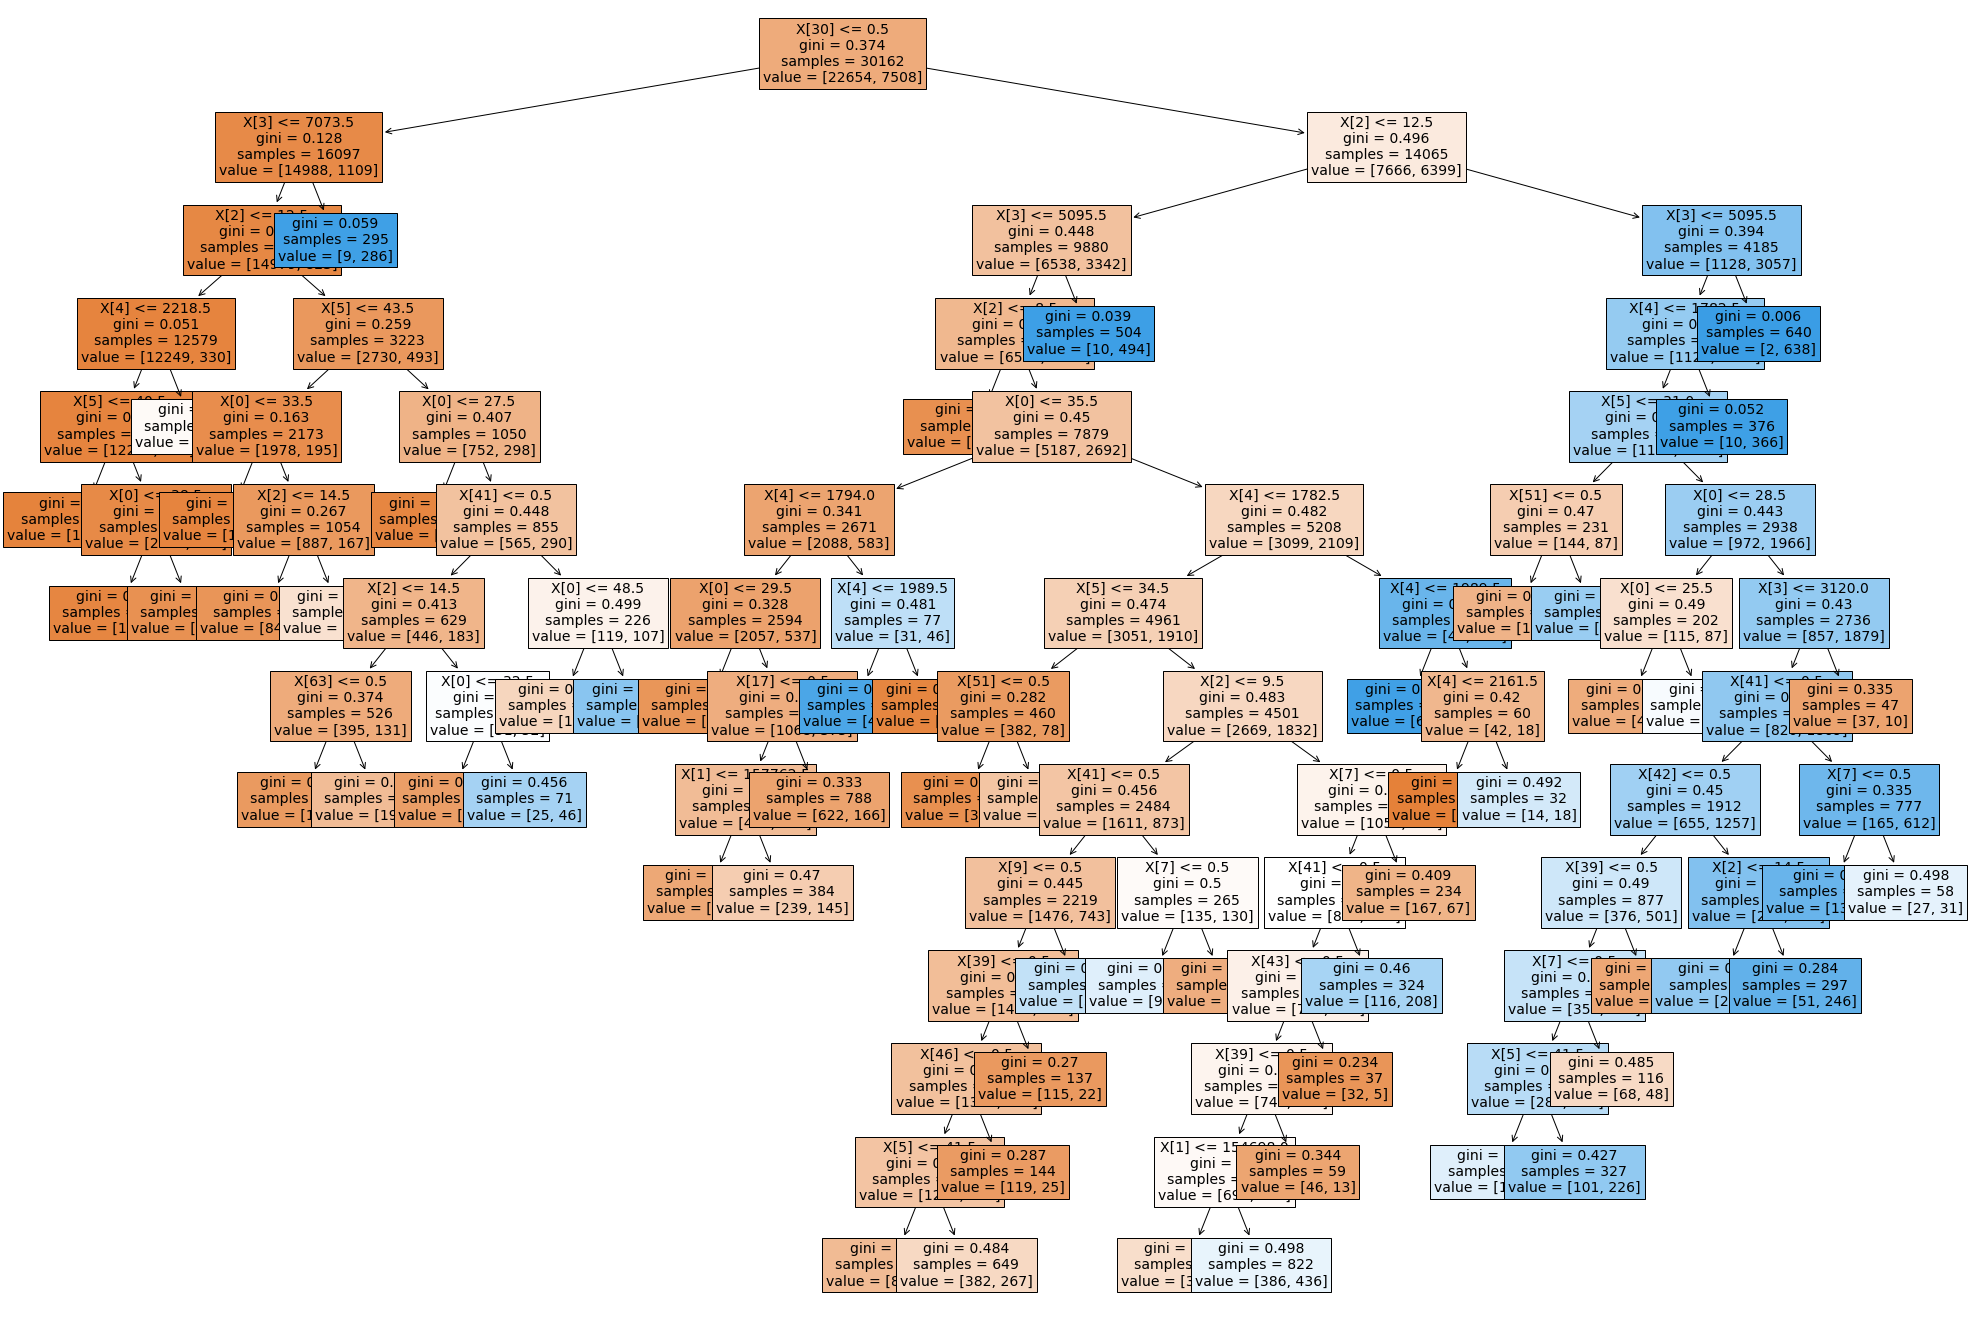

In [103]:
from sklearn.tree import plot_tree
best_model.fit(X_train, y_train)
plt.figure(figsize=(34,24))
plot_tree(best_model, filled=True, fontsize=14)
plt.show()

### Testing

In [131]:
y_pred = best_decistion_tree_model.predict(X_test)
acc = np.mean(y_pred == y_test)
print('accuracy = ', f'{acc:.4f}')


NotFittedError: ignored

# Dataset 2 - Student Performance

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle

## Data Prep

In this dataset, we're given the data of 649 Portuguese students and asked to predict their final trimester grades (G3) in math.

The dataset has no missing data, so there's no imputation involved.

Data source: https://archive.ics.uci.edu/ml/datasets/Student+Performance

In [180]:
df = pd.read_csv('./student-mat.csv', sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [181]:
#split df into categorical and numerical features
cat_df = df.select_dtypes(include='object')
num_df = df.select_dtypes(include='int64')

onehot_df = pd.DataFrame.copy(df)

for feature in cat_df.columns:
    onehot_cols = pd.get_dummies(df[feature], prefix=feature)
    
    onehot_df = onehot_df.drop(columns=feature)
    onehot_df = pd.concat([onehot_df, onehot_cols], axis=1)

In [182]:
onehot_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


In the Portuguese grading system, a score of 10+ is a pass. Let's make things a bit simpler for our decision trees and try to predict if a student passes or fails in the third semester. 

To do that, we turn the G3 column into a binary one.

In [183]:
#But first, make sure our classes are sufficiently populated
onehot_df.loc[onehot_df.G3 < 10].shape

(130, 59)

Almost a fifth of the students failed :(

In [185]:
onehot_df.loc[onehot_df.G3 < 10, 'G3'] = 0
onehot_df.loc[onehot_df.G3 >= 10, 'G3'] = 1

onehot_df.G3.head()

0    0
1    0
2    1
3    1
4    1
Name: G3, dtype: int64

Before we train, let's split off 20% of the data for testing.

In [208]:
X_train, X_test, y_train, y_test = train_test_split(onehot_df.drop(columns='G3'), onehot_df.G3, test_size=0.2, random_state=42)

## Training

### KNN

Let's find a best KNN model. All the code here is Elvin's. Thank you!

In [209]:
k_values = np.arange(1, 50)

best_acc = 0
accuracy = np.zeros(50)

from sklearn.model_selection import cross_val_score

for n_neighbors in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    #find the best 5-fold cross validation score accuracy
    acc = cross_validation(knn_model, X_train, y_train)
    accuracy[n_neighbors] = acc
    if acc > best_acc:
        best_K = n_neighbors
        best_acc = acc
        best_knn = knn_model

In [210]:
best_acc

0.8952380952380953

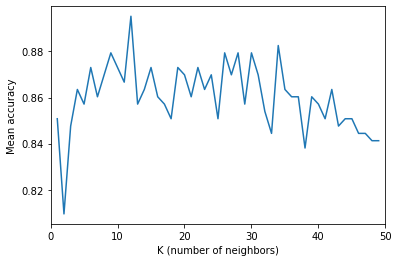

In [211]:
plt.plot(k_values, accuracy[1:])
plt.xlim(0,50)
#plt.ylim(0.7,0.8)
plt.ylabel('Mean accuracy')
plt.xlabel('K (number of neighbors)')
plt.show()

### Decision Tree

Now let's find a best decision tree. It's a wee bit more complicated, since there is so much space to search through. Potentially we could search through an extensive list of combinations: 

Most of the code is Elvin's again.

In [212]:
#choices of hyperparameter 
max_depth_values = np.arange(5, 16)
min_samples_leaf_values = np.arange(10,40) * 2
min_impurity_decrease_values = np.arange(20) * 0.00002


total_models = max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size
accuracy = np.zeros(max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size).reshape(max_depth_values.size, min_samples_leaf_values.size, min_impurity_decrease_values.size)
best_acc = 0
cur_per, count = -1, 0

#try all hyperparameter combinations
for max_depth in range(max_depth_values.size):
    for min_samples_leaf in  range(min_samples_leaf_values.size):
        for min_impurity_decrease in range(min_impurity_decrease_values.size):
            clf = DecisionTreeClassifier(max_depth=max_depth_values[max_depth], min_samples_leaf=min_samples_leaf_values[min_samples_leaf], min_impurity_decrease=min_impurity_decrease_values[min_impurity_decrease])
            #find the best 5-fold cross validation score accuracy
            acc = cross_val_score(clf, X_train, y_train, cv=5).mean()
            accuracy[max_depth, min_samples_leaf, min_impurity_decrease] = acc
            if acc > best_acc:
                best_cfg = (max_depth_values[max_depth], min_samples_leaf_values[min_samples_leaf], min_impurity_decrease_values[min_impurity_decrease])
                best_acc = acc
                best_tree = clf

In [215]:
print(best_acc, best_cfg)

0.9207341269841269 (5, 20, 0.0)


## Prediction

Let's predict these students' G3 grades using their earlier grades and other details.

In [216]:
best_tree.fit(X_train, y_train)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=12)

In [217]:
tree_pred = best_tree.predict(X_test)
knn_pred = best_knn.predict(X_test)

KNN doesn't do very bad.

In [218]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_pred)
metrics.auc(fpr, tpr)

0.8586182336182336

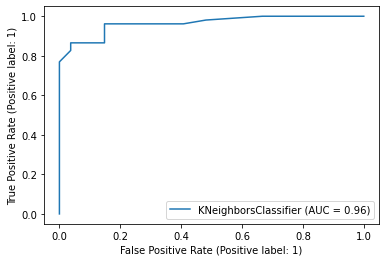

In [219]:
metrics.plot_roc_curve(best_knn, X_test, y_test)

But it looks like decision tree is a winner.

In [220]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_pred)
metrics.auc(fpr, tpr)

0.9237891737891738

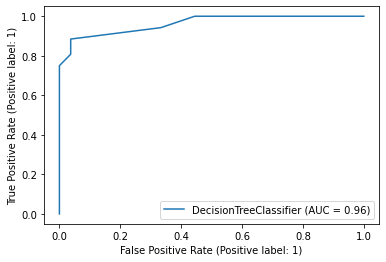

In [221]:
metrics.plot_roc_curve(best_tree, X_test, y_test)

## Feature selection experiments

Intuitively and as noted in the dataset description, previous grades are the most useful predictor for the final grade. And indeed, it looks like the reason our tree does well is simply because it checks whether the student passed the last trimester.

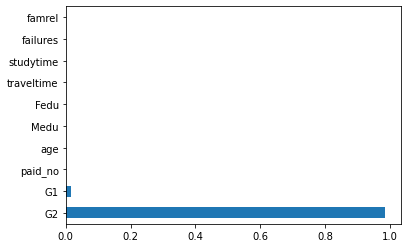

In [222]:
feat_importances = pd.Series(best_tree.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Let's drop the previous grades and see what happens to our tree.

In [223]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(onehot_df.drop(columns=['G3', 'G2', 'G1']), onehot_df.G3, test_size=0.2, random_state=42)

no_grade_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_impurity_decrease=0.0)

no_grade_tree.fit(X_train_new, y_train_new)
pred = no_grade_tree.predict(X_test_new)
fpr, tpr, thresholds = metrics.roc_curve(y_test_new, pred)
metrics.auc(fpr, tpr)

0.5705128205128205

In [224]:
metrics.plot_roc_curve(no_grade_tree, X_test, y_test)

ValueError: X has 58 features, but DecisionTreeClassifier is expecting 56 features as input.

Oof. Without grades, what's predicting the students' performance?

In [207]:
feat_importances = pd.Series(no_grade_tree.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

ValueError: Length of passed values is 56, index implies 58.

Previous failures and abscences from class. That makes sense, intuitively! Gender also seems to play a role, but our decision tree is somewhat bad, so it should be taken with a grain of salt.

All that said, our hyperparameters were optimized for a different dataset, so we might not be giving the tree its best shot. 

## Randomized Grid Search

Before we optimize the new tree, let's try a different method of hyperparameter search. Running through all the hyperparameter combos takes a long time, so let's try picking and testing random sets.

In [ ]:
def random_tree_optimization(X_train, y_train):

    #choices of hyperparameter 
    max_depth_values = np.arange(5, 16)
    min_samples_leaf_values = np.arange(10,40) * 2
    min_impurity_decrease_values = np.arange(20) * 0.00002

    n_sets_to_sample = 20

    total_models = max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size
    #accuracy = np.zeros(max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size).reshape(max_depth_values.size, min_samples_leaf_values.size, min_impurity_decrease_values.size)
    best_acc = 0
    cur_per, count = -1, 0

    for i in range(n_sets_to_sample):

        max_depth = np.random.choice(max_depth_values)
        min_split = np.random.choice(min_samples_leaf_values)
        min_impurity = np.random.choice(min_impurity_decrease_values)

        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_split, min_impurity_decrease=min_impurity)
        #find the best 5-fold cross validation score accuracy
        acc = cross_val_score(clf, X_train, y_train, cv=5).mean()
        #accuracy[max_depth, min_samples_leaf, min_impurity_decrease] = acc
        if acc > best_acc:
            best_cfg = (max_depth, min_split, min_impurity)
            best_acc = acc
            best_tree = clf
            
    return best_cfg, best_acc, best_tree


In [ ]:
best_cfg, best_acc, best_model = random_tree_optimization(X_train, y_train)

print(best_acc, best_cfg)

Very similar max accuracy to the thorough search, but also a different optimized hyperparameter set!

Let's use our new method to optimize the no grade tree.

In [ ]:
best_cfg, best_acc, best_model_no_grade = random_tree_optimization(X_train_new, y_train_new)

best_model_no_grade.fit(X_train_new, y_train_new)
pred = best_model_no_grade.predict(X_test_new)
fpr, tpr, thresholds = metrics.roc_curve(y_test_new, pred)
metrics.auc(fpr, tpr)

In [214]:
metrics.plot_roc_curve(best_model_no_grade, X_test_new, y_test_new)

NameError: name 'best_model_no_grade' is not defined

Still not the best model in the world.

In [ ]:
feat_importances = pd.Series(best_model_no_grade.feature_importances_, index=X_test_new.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Oh, hey, the feature importances changed in the better model! Failures, absences and gender are all important predictors, and health seems to play a role as well. All of them make some intuitive sense. 